<h1>Movie Recommendation System</h1>

<h2>Introduction</h2>

In the age of digital entertainment, finding the perfect movie to watch can be a daunting task given the vast array of options available. A Movie Recommendation System aims to simplify this process by leveraging data to suggest movies that align with the user's preferences. This project focuses on building a recommendation system that provides personalized movie suggestions based on various attributes such as genres, ratings, and other metadata.

The main objective of this project is to develop a system that analyzes a movie dataset to find films similar to a given movie. This system leverages cosine similarity, a metric that measures how similar movies are based on their attributes, to deliver accurate recommendations.

The dataset was derived from Kaggle https://www.kaggle.com/code/thedevastator/imdb-5000-movies-multiple-genres-dataset. It displays different about each movie like director, actors, genres etc. The raw dataset contains ten columns with a mix of categorical and quantitative values, offering a comprehensive view of each movie’s attributes.

In [1]:
#Necessary libraries were loaded

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

<h2>Loading Data</h2>

Dataset from the web was loaded.

In [2]:
df = pd.read_csv('IMDb_Movies.csv')
df.head()

,Movie_Title,Year,Director,Actors,Rating,Runtime(Mins),Censor,Total_Gross,main_genre,side_genre
0,Kantara,2022,Rishab Shetty,"Rishab Shetty, Sapthami Gowda, Kishore Kumar G...",9.3,148,UA,Gross Unkown,Action,"Adventure, Drama"
1,The Dark Knight,2008,Christopher Nolan,"Christian Bale, Heath Ledger, Aaron Eckhart, M...",9.0,152,UA,$534.86M,Action,"Crime, Drama"
2,The Lord of the Rings: The Return of the King,2003,Peter Jackson,"Elijah Wood, Viggo Mortensen, Ian McKellen, Or...",9.0,201,U,$377.85M,Action,"Adventure, Drama"
3,Inception,2010,Christopher Nolan,"Leonardo DiCaprio, Joseph Gordon-Levitt, Ellio...",8.8,148,UA,$292.58M,Action,"Adventure, Sci-Fi"
4,The Lord of the Rings: The Two Towers,2002,Peter Jackson,"Elijah Wood, Ian McKellen, Viggo Mortensen, Or...",8.8,179,UA,$342.55M,Action,"Adventure, Drama"


The dataset used has ***5562*** unique movies and the following columns:
- `Movie_Title` : The title of the movie.
- `Year` : The year the movie was released.
- `Director` : The director of the movie.
- `Actors` : The cast of the movie.
- `Rating` : The average rating of the movie.
- `Runtime (Mins)` : The duration of the movie.
- `Censor` : The age rating of the movie.
- `Total_Gross` : The total revenue generated by the movie.
- `main_genre` : The primary genre of the movie.
- `side_genre` : Any additional genres associated with the movie.


<h2>Tidying the Dataset</h2>

In the dataset, we counted the number of missing (`NA`) values in each column.

In [3]:
df.isnull().sum()

Movie_Title      0
Year             0
Director         0
Actors           0
Rating           0
Runtime(Mins)    0
Censor           0
Total_Gross      0
main_genre       0
side_genre       0
dtype: int64

Since there are no columns with `NA` values, we do not need to drop any rows from the dataset.

However, in the dataset above we notice that the movies have some columns that are not very relevant for recommending movies. So, we drop the following columns:
- `Runtime(Mins)`
- `Total_Gross`

Moreover, the `Censor` column has many values that have the same meaning but have been written differently. So, we standardized these values to ensure consistency across the dataset.

In [4]:
# Dropped the columns that weren't necessary for the recommendation
df = df.drop(['Runtime(Mins)', 'Total_Gross'], axis=1)

#Tidying up the Censor column
df['Censor'] = df['Censor'].replace('18+', 'R')
df['Censor'] = df['Censor'].replace('18', 'A')
df['Censor'] = df['Censor'].replace('R', 'A')
df['Censor'] = df['Censor'].replace('PG', 'UA')
df['Censor'] = df['Censor'].replace('All', 'U')
df['Censor'] = df['Censor'].replace('Unrated', 'Not Rated')
df['Censor'] = df['Censor'].replace('PG-13', '13')
df['Censor'] = df['Censor'].replace('12+', '13')
df = df[df['Censor'] != '(Banned)']

df.head()

,Movie_Title,Year,Director,Actors,Rating,Censor,main_genre,side_genre
0,Kantara,2022,Rishab Shetty,"Rishab Shetty, Sapthami Gowda, Kishore Kumar G...",9.3,UA,Action,"Adventure, Drama"
1,The Dark Knight,2008,Christopher Nolan,"Christian Bale, Heath Ledger, Aaron Eckhart, M...",9.0,UA,Action,"Crime, Drama"
2,The Lord of the Rings: The Return of the King,2003,Peter Jackson,"Elijah Wood, Viggo Mortensen, Ian McKellen, Or...",9.0,U,Action,"Adventure, Drama"
3,Inception,2010,Christopher Nolan,"Leonardo DiCaprio, Joseph Gordon-Levitt, Ellio...",8.8,UA,Action,"Adventure, Sci-Fi"
4,The Lord of the Rings: The Two Towers,2002,Peter Jackson,"Elijah Wood, Ian McKellen, Viggo Mortensen, Or...",8.8,UA,Action,"Adventure, Drama"


<h2>Data Visualization</h2>

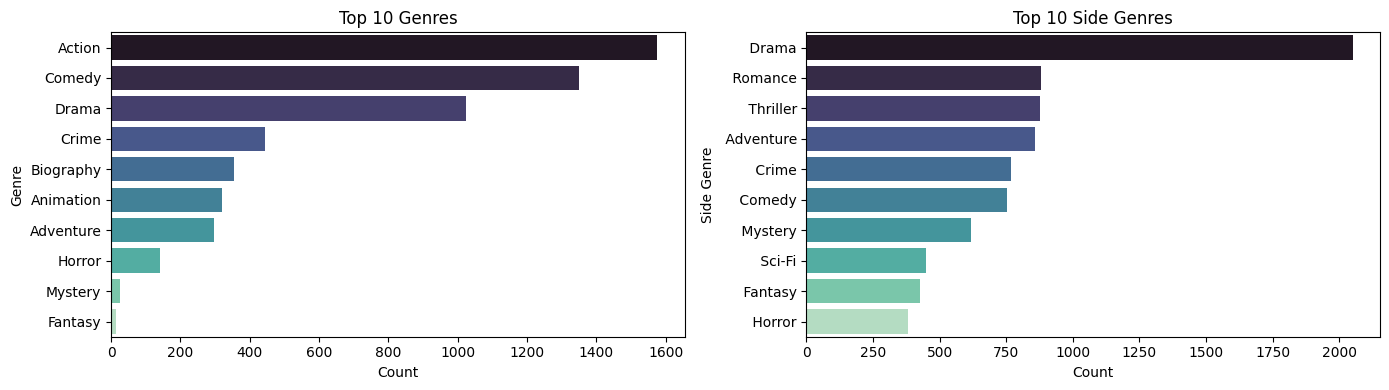

In [17]:
# Data preparation for main genres
df['main_genre'] = df['main_genre'].str.split(',')
df = df.explode('main_genre')
df['main_genre'] = df['main_genre'].str.strip()


# Count genres
genre_counts = df['main_genre'].value_counts()
genre_counts_df = genre_counts.reset_index()
genre_counts_df.columns = ['Genre', 'Count']

# Data preparation for side genres
df_copy = df.copy()
df_copy['side_genre'] = df_copy['side_genre'].str.split(', ')
side_genre_df = df_copy.explode('side_genre')

side_genre_counts = side_genre_df['side_genre'].value_counts()
side_genre_counts_df = side_genre_counts.reset_index()
side_genre_counts_df.columns = ['Side Genre', 'Count']

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Top 10 main genres
top_genres = genre_counts_df.head(10)
sns.barplot(x='Count', y='Genre', data=top_genres, palette='mako', ax=axes[0], hue='Genre', legend=False)
axes[0].set_title('Top 10 Genres')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Genre')

# Top 10 side genres
top_side_genres = side_genre_counts_df.head(10)
sns.barplot(x='Count', y='Side Genre', data=top_side_genres, palette='mako', ax=axes[1], hue='Side Genre', legend=False)
axes[1].set_title('Top 10 Side Genres')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Side Genre')

# Adjust layout
plt.tight_layout()
plt.show()

I processed and visualized the top 10 main and side genres. This helped me identify the most common genres in the dataset and understand the trends.

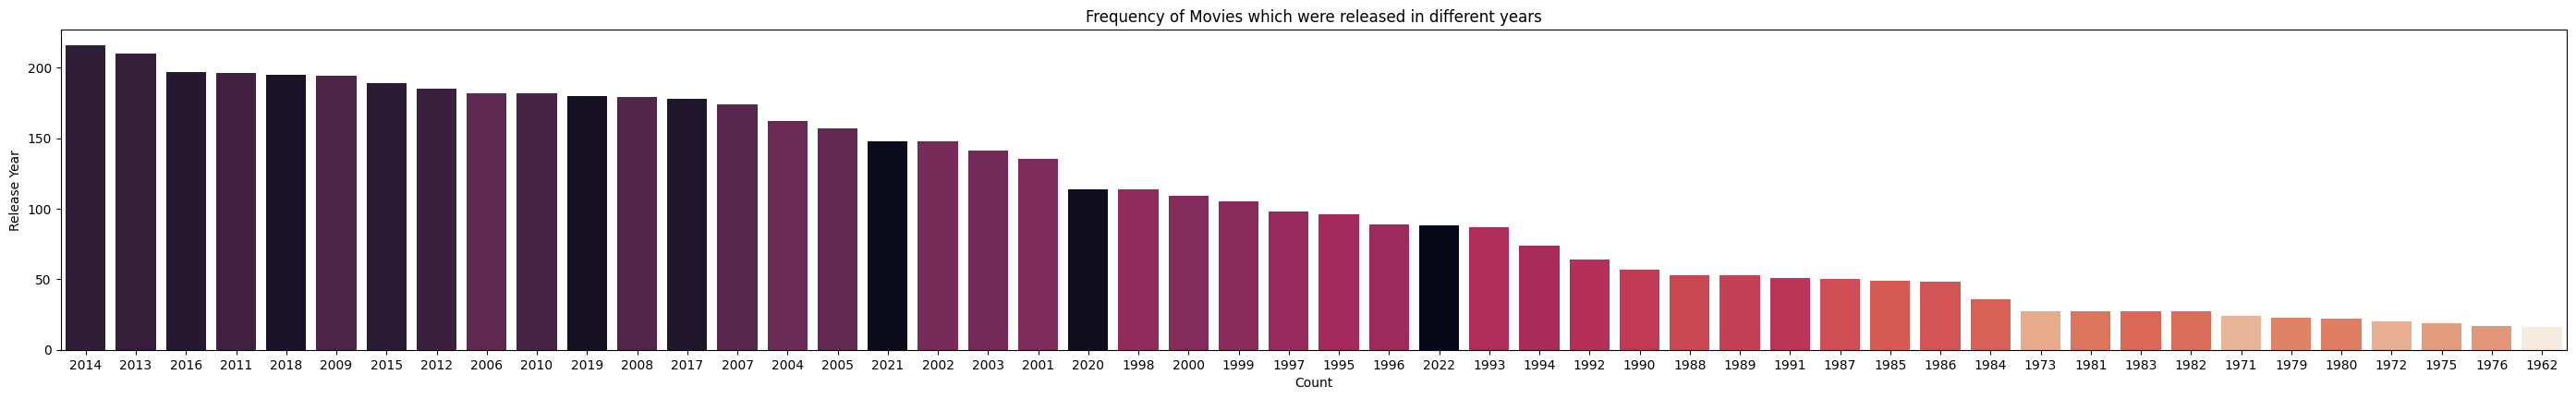

In [7]:
plt.figure(figsize=(35, 4.5))

year_counts = df['Year'].value_counts().sort_values(ascending=False)
top_50_years = year_counts.head(50)
df_top_50 = df[df['Year'].isin(top_50_years.index)]

sns.countplot(x='Year', data=df_top_50, palette='rocket_r', order=top_50_years.index, hue='Year', legend=False)

plt.title('Frequency of Movies which were released in different years')
plt.xlabel('Count')
plt.ylabel('Release Year')
plt.show()

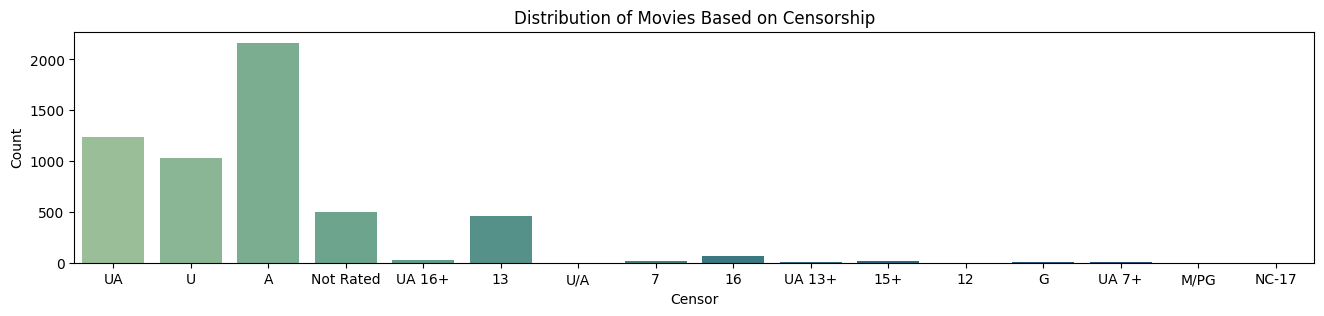

In [8]:
plt.figure(figsize=(16, 3))
sns.countplot(x='Censor',data = df, palette='crest', hue='Censor', legend=False)

plt.title('Distribution of Movies Based on Censorship')
plt.xlabel('Censor')
plt.ylabel('Count')
plt.show()

<h2>Movie Recommendation System</h2>

In [9]:
def preprocess_data(df):
    # One-hot encode categorical columns
    categorical_cols = ['main_genre', 'side_genre', 'Director', 'Actors', 'Censor']
    df_encoded = pd.get_dummies(df[categorical_cols])

    # Scale numerical columns
    numerical_cols = ['Rating','Year']
    df_numerical = df[numerical_cols]
    df_numerical = (df_numerical - df_numerical.mean()) / df_numerical.std()

    # Combine all features
    df_combined = pd.concat([df_encoded, df_numerical], axis=1)
    
    return df_combined

df_combined = preprocess_data(df)
df_combined.head()

,main_genre_Action,main_genre_Adventure,main_genre_Animation,main_genre_Biography,main_genre_Comedy,main_genre_Crime,main_genre_Drama,main_genre_Fantasy,main_genre_Film-Noir,main_genre_Horror,...,Censor_NC-17,Censor_Not Rated,Censor_U,Censor_U/A,Censor_UA,Censor_UA 13+,Censor_UA 16+,Censor_UA 7+,Rating,Year
0,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,2.715179,1.189900
1,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,2.394986,0.322998
2,True,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,2.394986,0.013390
3,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,2.181525,0.446841
4,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,2.181525,-0.048532


The `preprocess_data(df)` function converts the categorical columns (`main_genre`, `side_genre`, `Director`, `Actors`, `Censor`) into numerical format using one-hot encoding, creating binary columns for each unique category. It then normalizes the `Rating` and `Year` columns by subtracting the mean and dividing by the standard deviation, ensuring that the numerical data is on a similar scale. Finally, it combines the processed data into a single dataFrame, `df_combined`.

In [10]:
def compute_similarity(df_combined):
    similarity_matrix = cosine_similarity(df_combined)
    
    return similarity_matrix

similarity_matrix = compute_similarity(df_combined)

The `compute_similarity(df_combined)` function calculates and returns a matrix of cosine similarity scores for all rows in `df_combined`, which helps in understanding the similarity between different movies based on their features.

***Cosine Similarity*** : Measures the cosine of the angle between two non-zero vectors. In this context, it quantifies how similar two rows (or items) are to each other based on their features, with a value ranging from -1 (completely dissimilar) to 1 (completely similar).

In [18]:
def analyze_movie_similarity(movie_title, df, similarity_matrix, top_n=5):
    movie_idx = df.index[df['Movie_Title'] == movie_title].tolist()[0]
    
    # Get the similarity scores for the movie
    similarity_scores = similarity_matrix[movie_idx]
    
    # Sort indices based on similarity scores
    # we use (index+1) because the first index is the movie itself
    similar_movie_indices = np.argsort(-similarity_scores)[1:top_n+1]
    
    similar_movies = df.iloc[similar_movie_indices]
    
    result_df = pd.DataFrame({
        'Movie_Title': similar_movies['Movie_Title'],
        'Year': similar_movies['Year'],
        'Director': similar_movies['Director'],
        'Caste': similar_movies['Actors'],
        'Rating': similar_movies['Rating'],
        'Main_Genre': similar_movies['main_genre'],
        'Side_Genre': similar_movies['side_genre'],
        'Similarity_Score': similarity_scores[similar_movie_indices]
    })
    
    return result_df

def plot_similarity_scores(result_df, movie_title):
    plt.figure(figsize=(7, 3))
    sns.barplot(x=result_df['Movie_Title'], y=result_df['Similarity_Score'])
    plt.title(f"Similarity Scores for Top {len(result_df)} Movies Similar to '{movie_title}'")
    plt.xlabel("Movie Title")
    plt.ylabel("Similarity Score")
    plt.xticks(rotation=45)
    plt.show()

The `analyze_movie_similarity(movie_title, df, similarity_matrix, top_n=5)` function provides a list of movies similar to the given movie, `movie_title`, based on similarity scores. It helps in recommending or exploring movies similar to a specified title by leveraging a precomputed similarity matrix.

While, the `plot_similarity_scores(result_df, movie_title)` function visualizes a bar plot showing how similar each of the top movies is to a specified movie, making it easier to visually compare the similarity scores.

In [19]:
def similar_movies(df):
    final_df = df.drop(['Similarity_Score'], axis=1)
    return final_df

Finally, `similar_movies(df)` function prepares the dataset for the final output.

<h2>Recommending Movies</h2>

In [20]:
movie_name = input("Enter the name of movie?\n")

Enter the name of movie?
 Kantara


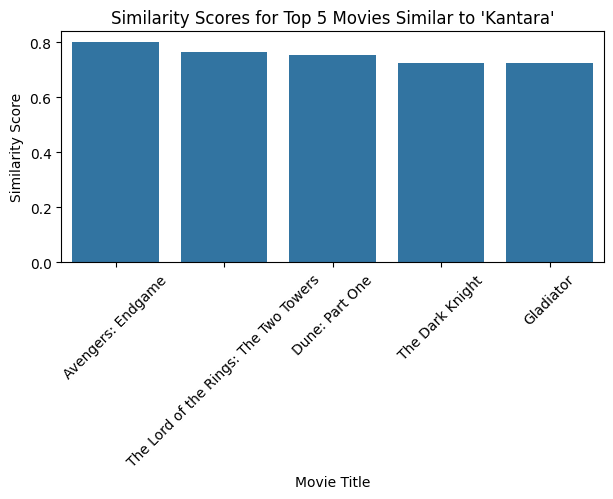

In [21]:
similar_movies_df = analyze_movie_similarity(movie_name, df, similarity_matrix, top_n=5)
plot_similarity_scores(similar_movies_df, movie_name)

In [25]:
print("Finally, Movies similar to", movie_name, "are : ")
similar_movies(similar_movies_df)

Finally, Movies similar to Kantara are : 


,Movie_Title,Year,Director,Caste,Rating,Main_Genre,Side_Genre
19,Avengers: Endgame,2019,"Directors:Anthony Russo, Joe Russo","Robert Downey Jr., Chris Evans, Mark Ruffalo, ...",8.4,Action,"Adventure, Drama"
4,The Lord of the Rings: The Two Towers,2002,Peter Jackson,"Elijah Wood, Ian McKellen, Viggo Mortensen, Or...",8.8,Action,"Adventure, Drama"
89,Dune: Part One,2021,Denis Villeneuve,"Timothée Chalamet, Rebecca Ferguson, Zendaya, ...",8.0,Action,"Adventure, Drama"
1,The Dark Knight,2008,Christopher Nolan,"Christian Bale, Heath Ledger, Aaron Eckhart, M...",9.0,Action,"Crime, Drama"
15,Gladiator,2000,Ridley Scott,"Russell Crowe, Joaquin Phoenix, Connie Nielsen...",8.5,Action,"Adventure, Drama"


<h2>~Thank You~</h2>